In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt


import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Set plotting parameters
plt.rcParams.update({
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'axes.xmargin': 0,
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'axes.labelsize': 14,
    "axes.titlesize": 16,
    'xtick.labelsize': 12,
    'axes.titlepad': 20,
    'ytick.labelsize': 12,
    'grid.linewidth': 0.5
})

In [2]:
features = pd.read_csv("../features_tweaked.csv")

C:\Users\scbui\AppData\Local\Temp\ipykernel_17344\1846429560.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv("../features_tweaked.csv")


In [29]:
metadata_columns = ['Respondent', 'Participant_ID', 'mean_rating', 'Participant_ID_short',
       'image_number', 'individual_ratings', 'ID', 'Type', "class", "Missing"]

X = features.drop(metadata_columns, axis = 1)
y = features["individual_ratings"]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
def train_model(_X, _y, _ep): #Function to train a model based on X, y and learning rate

    n = _X.shape[1]

    model = keras.models.Sequential()
    model.add(Dense(n, input_shape = _X.shape[1:], activation="relu"))
    model.add(Dense(300, activation="relu"))
    model.add(Dense(200, activation="relu")) # less layers seem to work a bit better...
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(1))

    opt = Adam(learning_rate = 1e-5) # 1e-4 works for adam 
    model.compile(loss="mean_squared_error", optimizer=opt)

    history = model.fit(_X, _y, epochs = _ep, validation_split = 0.1, verbose = 0)

    return model, history

In [30]:

RMSEs = []
stds = []
HIS2 = []

# epochs = np.linspace(30, 120, 20, dtype=int)
epochs = [110]

for ep in tqdm(epochs):
    print(f"Training model for $_epoch = {ep}$")
    temp_RMSEs = []

    for i in range(5): #Each model is trained x times

        _m, history = train_model(X_train_scaled, y_train, ep)

        performance = np.sqrt(np.mean((_m.predict(X_test_scaled[0:]).flatten() - np.array(y_test))**2))
        HIS2.append(history.history)
        temp_RMSEs.append(performance)
    print(f"Temp_RMSE = {temp_RMSEs}")

    RMSEs.append(np.mean(temp_RMSEs))
    stds.append(np.std(temp_RMSEs))

print(f"Model total performance: {RMSEs} +- {stds}")

  0%|          | 0/1 [00:00<?, ?it/s]

Training model for $_epoch = 110$
10/10 [==============================] - 0s 5ms/step


100%|██████████| 1/1 [28:57<00:00, 1737.81s/it]

Temp_RMSE = [3.974402396856915, 3.6697261263895835, 3.5408067928546547, 3.701842601554145, 3.5114447178496055]
Model total performance: [3.6796445271009808] +- [0.16434136621557505]


# Load history

In [3]:
HIS4 = np.load("history_110epochs_1e-4.npy", allow_pickle=True)
HIS5 = np.load("history_110epochs_1e-5.npy", allow_pickle=True)

# History plot: seperate line per model

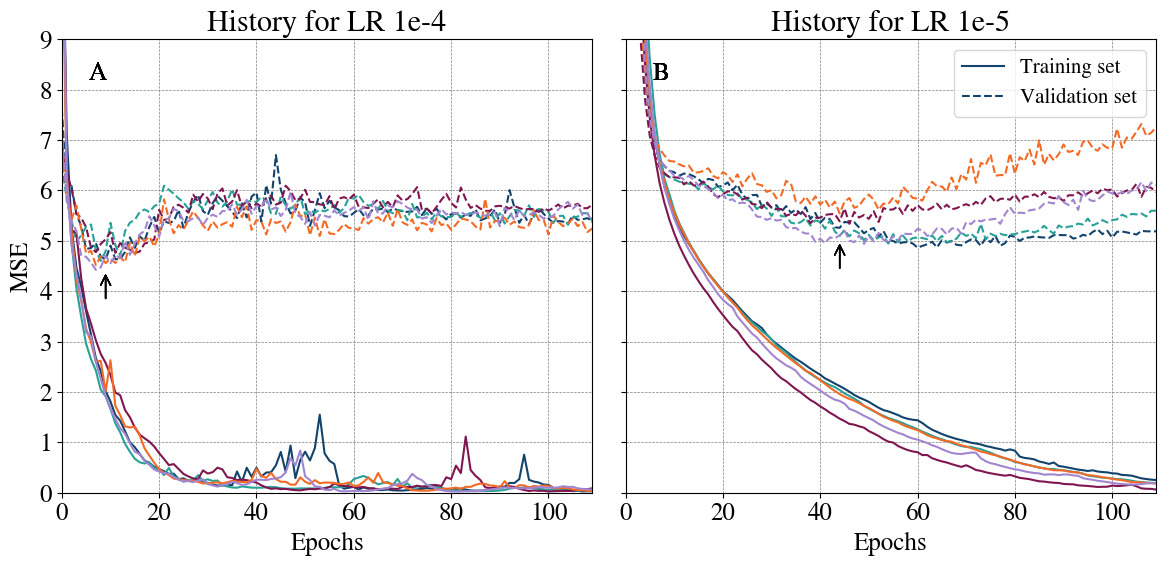

In [3]:
# Define colors for lines
colors = ['#12436D', '#28A197', '#801650', '#F46A25', '#A285D1']


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for HIS4
axs[0].set_title('History for LR 1e-4')
for i, history in enumerate(HIS4):
    axs[0].plot(history['loss'], color=colors[i], label=f'Model {i+1} loss')
    axs[0].plot(history['val_loss'], linestyle='--', color=colors[i], label=f'Model {i+1} val_loss')
    axs[0].set_ylim(0,9)
    axs[0].text(0.05, 0.95, 'A', transform=axs[0].transAxes, fontsize=18, va='top', ha='left')
    # Add arrow to the first subplot
    axs[0].annotate('', xy=(9, 4.4), xytext=(9, 3.8), arrowprops=dict(facecolor='black', arrowstyle='->'))
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("MSE")
    axs[0].grid(True)

# Plot for HIS5
axs[1].set_title('History for LR 1e-5')
for i, history in enumerate(HIS5):
    axs[1].plot(history['loss'], color=colors[i], label=f'Model {i+1} loss')
    axs[1].plot(history['val_loss'], linestyle='--', color=colors[i], label=f'Model {i+1} val_loss')
    axs[1].set_ylim(0,9)
    axs[1].text(0.05, 0.95, 'B', transform=axs[1].transAxes, fontsize=18,  va='top', ha='left')
    # Add arrow to the first subplot
    axs[1].annotate('', xy=(44, 5), xytext=(44, 4.4), arrowprops=dict(facecolor='black', arrowstyle='->'))
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc='upper right', fontsize='small')
    axs[1].grid(True)


axs[1].legend(handles=axs[1].lines[:1] + axs[1].lines[1:2], 
              labels=[f'Training set', f"Validation set"], 
              loc='upper right', fontsize='small')


# Show plot
plt.tight_layout()
plt.show()



# History plot: 95% CI

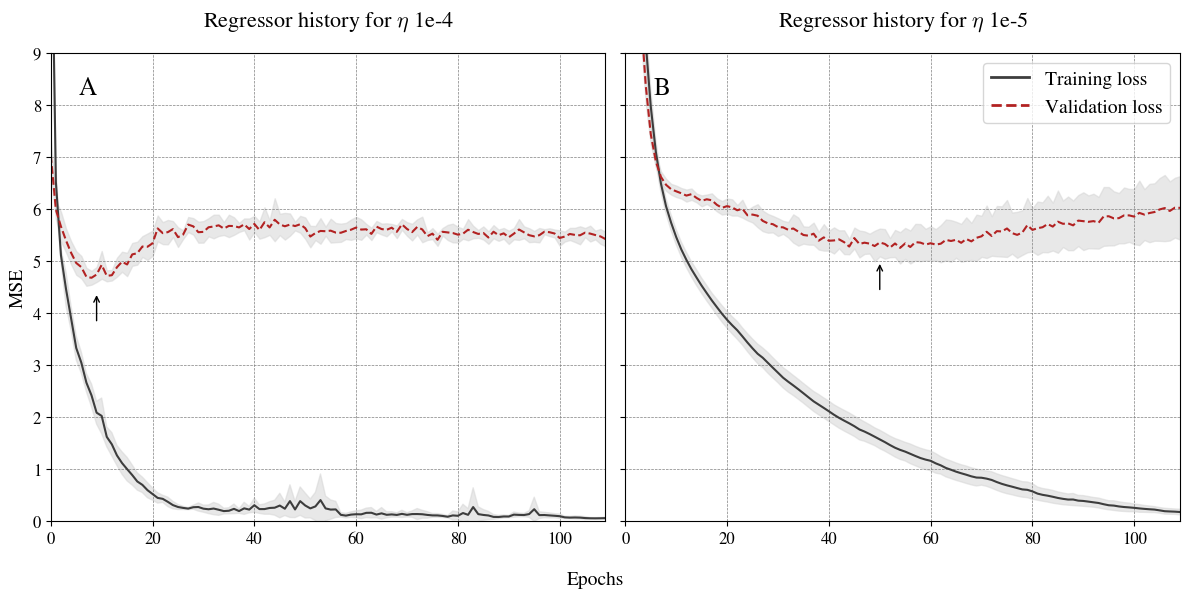

In [7]:
# Calculate the 95% confidence interval
def confidence_interval(data):
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    n = len(data)
    std_error = std_dev / np.sqrt(n)
    margin_of_error = 1.96 * std_error
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return mean, lower_bound, upper_bound


# Calculate mean and confidence interval for HIS4
loss_mean_HIS4, loss_lower_HIS4, loss_upper_HIS4 = confidence_interval([history['loss'] for history in HIS4])
val_loss_mean_HIS4, val_loss_lower_HIS4, val_loss_upper_HIS4 = confidence_interval([history['val_loss'] for history in HIS4])

# Calculate mean and confidence interval for HIS5
loss_mean_HIS5, loss_lower_HIS5, loss_upper_HIS5 = confidence_interval([history['loss'] for history in HIS5])
val_loss_mean_HIS5, val_loss_lower_HIS5, val_loss_upper_HIS5 = confidence_interval([history['val_loss'] for history in HIS5])

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex = True)

# Plot for HIS4
axs[0].set_title('Regressor history for $\eta$ 1e-4')
axs[0].plot(loss_mean_HIS4, color='#3D3D3D', label='Training loss')
axs[0].fill_between(range(len(loss_mean_HIS4)), loss_lower_HIS4, loss_upper_HIS4, color='lightgrey', alpha=0.5)
axs[0].plot(val_loss_mean_HIS4, linestyle='--', color='#B22222', label="Validation loss")
axs[0].fill_between(range(len(val_loss_mean_HIS4)), val_loss_lower_HIS4, val_loss_upper_HIS4, color='lightgrey', alpha=0.5)
# Add arrow to the first subplot
axs[0].annotate('', xy=(9, 4.4), xytext=(9, 3.8), arrowprops=dict(facecolor='black', arrowstyle='->'))
axs[0].set_ylabel("MSE")
axs[0].grid(True)
axs[0].set_ylim(0,9)
axs[0].text(0.05, 0.95, 'A', transform=axs[0].transAxes, fontsize=18, va='top', ha='left')

# Plot for HIS5
axs[1].set_title('Regressor history for $\eta$ 1e-5')
axs[1].plot(loss_mean_HIS5, color='#3D3D3D', label='Training loss')
axs[1].fill_between(range(len(loss_mean_HIS5)), loss_lower_HIS5, loss_upper_HIS5, color='lightgrey', alpha=0.5)
axs[1].plot(val_loss_mean_HIS5, linestyle='--', color='#B22222', label='Validation loss')
axs[1].fill_between(range(len(val_loss_mean_HIS5)), val_loss_lower_HIS5, val_loss_upper_HIS5, color='lightgrey', alpha=0.5)
# Add arrow to the second subplot
axs[1].annotate('', xy=(50, 5), xytext=(50, 4.4), arrowprops=dict(facecolor='black', arrowstyle='->'))
axs[1].legend(loc='upper right', fontsize='small')
axs[1].grid(True)
axs[1].set_ylim(0,9)
axs[1].text(0.05, 0.95, 'B', transform=axs[1].transAxes, fontsize=18, va='top', ha='left')

# Customize legend
handles = [plt.Line2D([0], [0], color='#3D3D3D', lw=2),
           plt.Line2D([0], [0], color='#B22222', linestyle='--', lw=2)]
labels = ['Training loss', 'Validation loss']
axs[1].legend(handles=handles, labels=labels, loc='upper right', fontsize=14)

# Show plot
fig.supxlabel("Epochs", fontsize = 14)

plt.tight_layout()
plt.savefig("../epochs_sweep_subplots.pdf", bbox_inches = "tight")
plt.show()


In [ ]:
loss

In [ ]:
np.save("lr_min2_min5_epochs.npy", epochs)
np.save("lr_min2_min5_RSME.npy", RMSEs)
np.save("lr_min2_min5_STD.npy", stds)

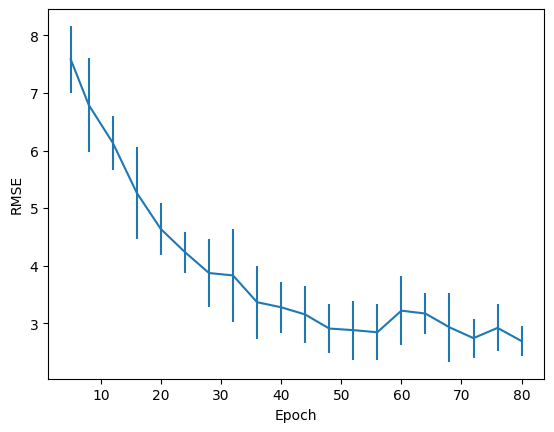

In [7]:
plt.figure()
plt.errorbar(epochs, RMSEs, stds)
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.show()


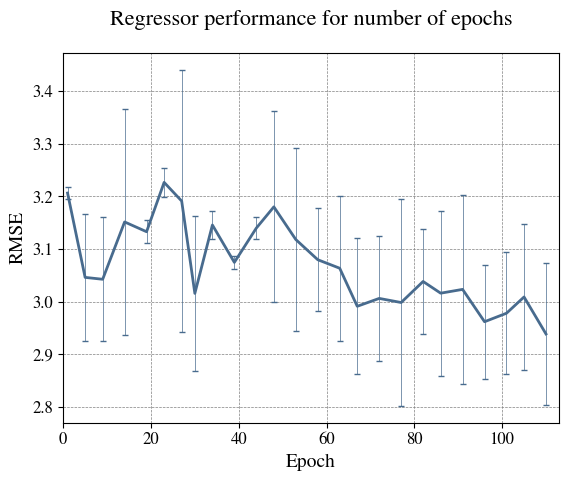

In [3]:
epochs = [1, 5, 9, 14, 19, 23, 27, 30, 34, 39, 44, 48, 53, 58, 63, 67, 72, 77, 82, 86, 91, 96, 101, 105, 110]
RMSEs = [3.20649746, 3.046385192, 3.042807581, 3.151672207, 3.133086346, 3.226809259, 3.191329873, 3.015995528, 3.14586094, 3.074896074, 3.139955356, 3.180309648, 3.11827414, 3.079936477, 3.063767825, 2.991507833, 3.006464918, 2.998664006, 3.03861046, 3.016388013, 3.023599415, 2.962196473, 2.978332715, 3.009174707, 2.938910118]
stds = [
    0.0116356651, 0.1204306081, 0.117666784, 0.2148712352, 0.02235329585, 0.0272871133, 
    0.249333984, 0.1472253423, 0.0259331495, 0.01253716358, 0.02118101511, 0.1814463306, 
    0.1739520806, 0.09764471919, 0.1372814117, 0.1289859611, 0.1182447117, 0.1960316028, 
    0.1004594961, 0.1569797132, 0.1789733742, 0.1082804066, 0.1156207757, 0.138389096, 
    0.1352798304
]
plt.figure()
plt.plot(epochs, RMSEs, marker='', color='#486B8E', linewidth=2) 
plt.errorbar(epochs, RMSEs, stds, fmt='none', capsize=2, color='#486B8E', linewidth=0.5)
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.savefig("epoch_sweep.pdf", format='pdf', bbox_inches = "tight")
plt.title("Regressor performance for number of epochs")
plt.grid(True)
plt.xlim(0, 113)

plt.savefig("epoch_sweep.pdf", format = "pdf", bbox_inches = "tight")
plt.show()